In [224]:
import pandas
import numpy 
import sklearn 
import csv
import matplotlib
import matplotlib.pyplot as pyplot
import matplotlib.ticker as ticker

from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
reg = linear_model.LinearRegression()

DRAFT_DATA_PATH = './data/draft_data_public.MKM.PremierDraft.csv'

NUM_IN_PACK = 13
NUM_PACKS = 3


In [134]:
with open(DRAFT_DATA_PATH) as csvfile:
    draft_data = csv.reader(csvfile)
    columns = next(draft_data)
        

NAMES = [col.split('pack_card_')[1] for col in columns if 'pack_card_' in col]
PICK_IDX = columns.index('pick')
DRAFTID_IDX = columns.index('draft_id')
DRAFTTIME_IDX = columns.index('draft_time')
PACKNUM_IDX = columns.index('pack_number')
PICKNUM_IDX = columns.index('pick_number')
MATCHWINS_IDX = columns.index('event_match_wins')
MATCHLOSSES_IDX = columns.index('event_match_losses')

PACK_IDX = columns.index('pack_card_A Killer Among Us')
POOL_IDX = columns.index('pool_A Killer Among Us')
NUM_CARDS = len(NAMES)

def card_vector(index, row):
    return numpy.array([int(x) for x in row[index:index + NUM_CARDS]])

In [142]:
record = {}

with open(DRAFT_DATA_PATH) as csvfile:
    draft_data = csv.reader(csvfile)
    columns = next(draft_data)
        
    
    for row in draft_data:
        draft_date = row[DRAFTTIME_IDX].split(' ')[0]

        if draft_date not in record:
            record[draft_date] = {
                'wins': numpy.zeros((NUM_CARDS, NUM_PACKS, NUM_IN_PACK), dtype=numpy.intc),
                'losses': numpy.zeros((NUM_CARDS, NUM_PACKS, NUM_IN_PACK), dtype=numpy.intc)
            }
            
        record[draft_date]['wins'][NAMES.index(row[PICK_IDX]), int(row[PACKNUM_IDX]), int(row[PICKNUM_IDX])] += int(row[MATCHWINS_IDX])
        record[draft_date]['losses'][NAMES.index(row[PICK_IDX]), int(row[PACKNUM_IDX]), int(row[PICKNUM_IDX])] += int(row[MATCHLOSSES_IDX])
        
    
        

In [168]:
record_list = list(record.values())
wins_list = [r['wins'] for r in record_list]
losses_list = [r['losses'] for r in record_list]

wins = numpy.array(wins_list)
losses = numpy.array(losses_list)

(42, 326, 3, 13)

In [169]:
wins_by_date = wins.sum(axis=2)
losses_by_date = losses.sum(axis=2)

wins_by_pack = wins.sum(axis=0)
losses_by_pack = losses.sum(axis=0)

In [170]:
wins_all = wins_by_pack.sum(axis=1)
losses_all = losses_by_pack.sum(axis=1)

matches_by_date = numpy.maximum(wins_by_date + losses_by_date, 1) # divide by zero
matches_by_pack = numpy.maximum(wins_by_pack + losses_by_pack, 1)
matches_all = matches_by_pack.sum(axis=1)

In [250]:
matches_by_card = matches_all.sum(axis=1)

In [193]:
wr_all = wins_all / matches_all
wr_all_diff = numpy.diff(wr_all)

wr_by_date = wins_by_date / matches_by_date
wr_by_date_diff = numpy.diff(wr_by_date)

wr_by_pack = wins_by_pack / matches_by_pack
wr_by_pack_diff = numpy.diff(wr_by_pack)

wr_avg_by_pack = wins_by_pack.sum(axis=2)/matches_by_pack.sum(axis=2)
wr_avg_by_date = wins_by_date.sum(axis=2)/matches_by_date.sum(axis=2)

ata_by_pack = (matches_by_pack * numpy.arange(1,14).reshape(1,1,13)).sum(axis=2) / matches_by_pack.sum(axis=2)
ata_by_date = (matches_by_date * numpy.arange(1,14).reshape(1,1,13)).sum(axis=2) / matches_by_date.sum(axis=2)

wr_avg = wins_all.sum(axis=1)/matches_all.sum(axis=1)
ata = (matches_all * numpy.arange(1,14).reshape(1,13)).sum(axis=1) / matches_all.sum(axis=1)

set_wr_avg = numpy.average(wr_avg, weights = matches_all.sum(axis=1))

wr_avg_by_date_norm = wr_avg_by_date - set_wr_avg

In [198]:
def pick_equity(ata, beta):
    # a quadratic function that is decreasing with slope beta at 0 and has value 0 at x=12
    return 6 * beta - beta * ata + ata * ata * beta / 24

In [183]:
def plot_card_ata_and_wr(card_name):
    fig, ax1 = pyplot.subplots()
    
    t = numpy.arange(1, ata_by_date.shape[0] + 1)
    
    color = 'tab:red'
    ax1.set_xlabel('Day Number')
    ax1.set_ylabel('As-Picked WR', color=color)
    ax1.plot(t, wr_avg_by_date[:,NAMES.index(card_name)], color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    
    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    
    color = 'tab:blue'
    ax2.set_ylabel('ATA', color=color)  # we already handled the x-label with ax1
    ax2.plot(t, ata_by_date[:, NAMES.index(card_name)], color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    pyplot.subplots()

In [217]:
def plot_card_deq(card_name, beta):
    fig, ax = pyplot.subplots()
    t = numpy.arange(1, ata_by_date.shape[0] + 1)

    wr_curve = wr_avg_by_date_norm[:, NAMES.index(card_name)]
    pick_equity_curve = pick_equity(ata_by_date[:, NAMES.index(card_name)], beta)

    sum_curve = wr_curve + pick_equity_curve

    ax.plot(t, wr_curve)
    ax.plot(t, pick_equity_curve)
    ax.plot(t, sum_curve)
    pyplot.show()
    

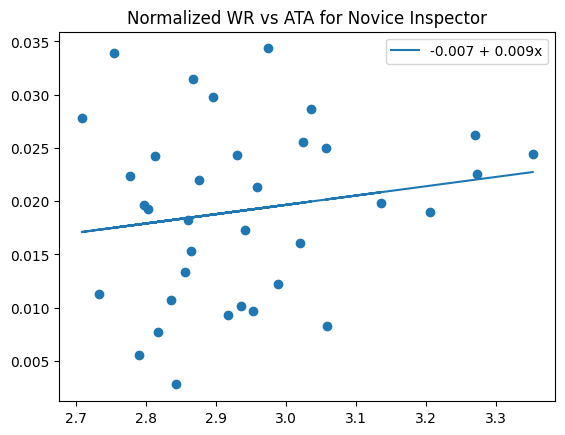

In [329]:
scatter_wr_vs_ata('Novice Inspector', 7)

In [328]:
def scatter_wr_vs_ata(card_name, ndays_cutoff=14):
    fig, ax = pyplot.subplots()
    wr_curve = wr_avg_by_date_norm[ndays_cutoff:, NAMES.index(card_name)]
    ata_curve = ata_by_date[ndays_cutoff:, NAMES.index(card_name)]

    ax.scatter(ata_curve, wr_curve)

    reg.fit(ata_curve.reshape(ata_curve.shape[0], 1), wr_curve.reshape(wr_curve.shape[0], 1))

    fit = ata_curve * reg.coef_[0][0] + reg.intercept_
    
    ax.plot(ata_curve, fit, label=f'{reg.intercept_[0]:.3f} + {reg.coef_[0][0]:.3f}x')
    ax.set_title(f'Normalized WR vs ATA for {card_name}')
    ax.legend()
    
    

def make_alpha(cutoff):
    def alpha(card_index):
        
        wr_curve = wr_avg_by_date_norm[cutoff:, card_index]
        ata_curve = ata_by_date[cutoff:, card_index]
    
        reg.fit(ata_curve.reshape(ata_curve.shape[0], 1), wr_curve.reshape(wr_curve.shape[0], 1))
    
        return reg.coef_[0][0]
    return alpha
    
    

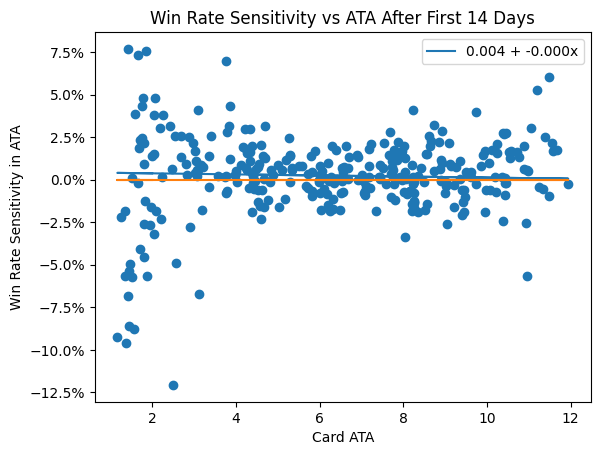

Implied p1 value: 2.21%


In [322]:
cutoff = 14
alphas = numpy.vectorize(make_alpha(cutoff))(numpy.arange(0, len(NAMES)))

fig, ax = pyplot.subplots()
ax.scatter(ata, alphas)

reg.fit(ata.reshape(ata.shape[0], 1), alphas.reshape(alphas.shape[0], 1), matches_by_card)
ax.plot(ata, reg.intercept_ + reg.coef_[0][0] * ata, label=f'{reg.intercept_[0]:.3f} + {reg.coef_[0][0]:.3f}x')
ax.plot(ata, numpy.zeros(ata.shape[0]))
ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=1))                             
ax.set_xlabel('Card ATA')
ax.set_ylabel('Win Rate Sensitivity in ATA')
ax.set_title(f'Win Rate Sensitivity vs ATA After First {cutoff} Days')
ax.legend()
pyplot.show()
print(f'Implied p1 value: {pick_equity(1, reg.intercept_[0]):.2%}')

In [299]:
reg.intercept_

array([0.02137547])

In [128]:
MIN_SAMPLE_SIZE = 5000

def decorate_wr_vs_pick_plot(ax):
    ax.set_xlabel('Pick Number')
    ax.set_ylabel('As-Picked Win Rate')
    ax.set_xticks(numpy.arange(1,14))

    ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=1))                             
    ax.legend()
    
def add_card_plot(card_name, ax):
    card = NAMES.index(card_name)
    valid_indices = numpy.argwhere(match_counts_all_packs[card] > MIN_SAMPLE_SIZE)

    if(len(valid_indices)):
        min_pick = valid_indices.min()
        max_pick = valid_indices.max()
            
        ax.plot(numpy.arange(min_pick+1, max_pick+2) ,match_wr[card][min_pick:max_pick+1], label=NAMES[card]) 
        ax.scatter(ata[card], match_wr_avg[card])

def add_card_plot_for_pack(card_name, pack_num, ax):
    card = NAMES.index(card_name)
    valid_indices = numpy.argwhere(match_counts[card, pack_num] > MIN_SAMPLE_SIZE)

    if(len(valid_indices)):
        min_pick = valid_indices.min()
        max_pick = valid_indices.max()
            
        ax.plot(numpy.arange(min_pick+1, max_pick+2) ,match_wr_by_pack[card, pack_num][min_pick:max_pick+1], label=NAMES[card] + f", Pack {pack_num + 1}") 
        ax.scatter(ata_by_pack[card, pack_num], match_wr_avg_by_pack[card, pack_num])


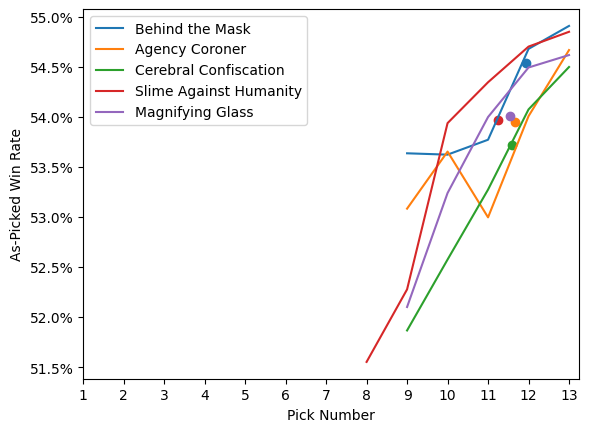

In [132]:
fig, ax = pyplot.subplots()
for card_name in ["Behind the Mask", "Agency Coroner", "Cerebral Confiscation", "Slime Against Humanity", "Magnifying Glass"]:
    add_card_plot(card_name, ax)
    
decorate_wr_vs_pick_plot(ax)


In [106]:
average_diff_0 = numpy.average(match_wr_diff_by_pack[:,0], axis=0, weights=numpy.minimum(match_counts[:,0,1:13], match_counts[:,0,0:12]))
average_diff = numpy.average(match_wr_diff, axis=0, weights=numpy.minimum(match_counts_all_packs[:,1:13], match_counts_all_packs[:,0:12]))

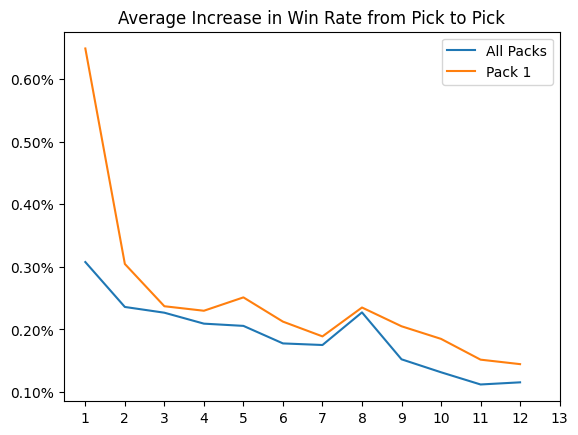

In [115]:
fix, ax = pyplot.subplots()
ax.plot(numpy.arange(1,13), average_diff, label='All Packs')
ax.plot(numpy.arange(1,13), average_diff_0, label='Pack 1')
ax.set_xticks(numpy.arange(1,14))
ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=2))
ax.set_title('Average Increase in Win Rate from Pick to Pick')
ax.legend()

In [108]:
average_diff_0.sum()

0.02994458965849588

In [139]:
row

['MKM',
 'PremierDraft',
 'd98849c988e340f69dde908ce0b95597',
 '2024-03-18 16:35:16',
 'platinum',
 '2',
 '3',
 '2',
 '12',
 'Jaded Analyst',
 '0.0',
 '0.0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '